<a href="https://colab.research.google.com/github/botelhoa/miscellaneous_notebooks/blob/main/yelp_review_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Author: Austin Botelho

# Imports and Installs 🛠️

In [ ]:
!pip install transformers==4.28.0 datasets scikit-learn accelerate

In [ ]:
import math
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support, accuracy_score
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.utils.logging import set_verbosity_error
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback, ProgressCallback, get_linear_schedule_with_warmup)
from typing import Iterable, Tuple
from collections import Counter
from transformers import TextClassificationPipeline


set_verbosity_error()


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
set_verbosity_error()

# 1.0) Data Exploration 🔎

### Load Data

First up, loading the data. I will sample the data for this exercise to reduce the runtime. I will also add an extra validation split to the data to prevent data contamination during training.

In [ ]:

def load(name: str, sample_size: float, split_size: float) -> Tuple[Dataset, Dataset, Dataset]:

    """

    Load, samples, and splits data

    Parameters:

        name (`str`): Name of dataset in HuggingFace Hub
        sample_size (`float`): Percentage of the data to take a stratified sample of
        split_size (`float`): Percent of data to reserve for evaluation

    """


    dataset = load_dataset(name)

    train = dataset["train"]
    train = train.train_test_split(test_size=sample_size, stratify_by_column="label", seed=22)["test"]
    train = train.train_test_split(test_size=split_size, stratify_by_column="label", seed=22)

    train_set = train["train"]
    val_set = train["test"]


    test = dataset["test"]
    test_set = test.train_test_split(test_size=sample_size, stratify_by_column="label", seed=22)["test"]

    return (train_set, val_set, test_set)



In [ ]:
train, val, test = load(name= "yelp_review_full", sample_size=0.01, split_size=0.2)

In [ ]:
print(f"Train shape: {train.shape}")
print(f"Val shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (5200, 2)
Val shape: (1300, 2)
Test shape: (500, 2)


### Visualize Data

In [ ]:
def show_example_for_each_rating(dataset: Dataset, n: int=1) -> None:
    """

    Displays a table with example text for each label class

    Parameters:
        dataset (`dataset`): Data with `text` and `label` features
        n (`int` default `1`): Number of examples to show per calss
    """

    data = []
    for i in set(dataset["label"]):

        temp_dataset = dataset.filter(lambda example: example["label"] == i)

        example_indices = np.random.randint(len(temp_dataset), size=n)
        example_text = temp_dataset.select(example_indices)

        data.append({
            "Label": i,
            "Example": "/n".join([i["text"] for i in example_text])
        })


    display(pd.DataFrame(data))


def top_adjectives_by_class(dataset: Dataset, n: int=10) -> None:

    """

    Display top n adjectives per label class

    Parameters:

        dataset (`dataset`): Data with `text` and `label` features
        n (`int` default `10`): Number of examples to show per calss

    """

    data = []
    #stops = set(pd.read_csv("https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords", header=None, names=['stopwords'])["stopwords"])
    adjectives = set(pd.read_csv("https://raw.githubusercontent.com/taikuukaits/SimpleWordlists/master/Wordlist-Adjectives-All.txt", header=None, names=['adjectives'])["adjectives"])


    for i in set(dataset["label"]):

        label_counter = Counter()

        temp_dataset = dataset.filter(lambda example: example["label"] == i)

        for text in temp_dataset["text"]:

            label_counter.update( set(text.split()) & set(adjectives) )

        data.append({
            "Label": i,
            "Most Common": label_counter.most_common(n)
        })


    display(pd.DataFrame(data))


It's always good to get a sense of what the data looks like. I will randomly sample one review for each star level. Seems the stars have also been re-indexed to be more pythonic.

In [ ]:
print("-----Train-----")
show_example_for_each_rating(train, n=1)

print("-----Val-----")
show_example_for_each_rating(val, n=1)

print("-----Test-----")
show_example_for_each_rating(test, n=1)

-----Train-----


Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

,Label,Example
0,0,Portions are large but it doesn't make up for the poor flavors. Ordered the fried pork with pepper and garlic: dripping with oil and very fatty portions of pork. Gang hunlae: pork was tender but the flavor was one dimensional. Fish is not fresh and tasted like a wet sock. Veggie dish has nice flavor but the oil saturated my tongues ability to taste anything. The steam rice had a pungent smell of pesticides. Service is average.
1,1,"i have been anxious to try this place and I did but sadly I was underwhelmed. I ordered the steak salad, the steak was very chewy, the salad had primarily iceberg lettuce.. really?? and a few cherry tomatoes. Very disappointing for the price. \n\nGo to Flemings... Who serves iceberg lettuce and if the steak was a disappointment what do you order"
2,2,"Sheesh, the last time I went to a BJs, I was screwing around in SoCal ages ago and probably couldn't afford a night of beer & pizza @ BJs on a student budget but went anyway...\n\nFast forward to today--which means my student budget hasn't really expanded but I still end up tryin out BJs again. Despite the myriad of beers, I knew what I was gettin--the sampler. The bartender had memorized the details regarding beers offered in their sampler, which was impressive. My six beers came with a place mat, describing each beer.\n\nBrewhouse blonde, hefeweizen, porter, a red, a stout, brewnette & an Oktoberfest were my selections. I know the other beers had more official names but the one I liked best was the one I remember the name to--'Brewhouse blonde'. It was light & a bit sweet. (I'm not a beer connoisseur & have been a Miller Lite girl since I started drinkin beer). \n\nWould I recommend you try it? Sure. My sentiment on the whole place/experience/atmosphere is exactly as rated 'A-OK'. Nothing fantabulous, nothing crazy. Just another chain that is less cheesy."
3,3,"Most of the time when you are here it is because you are sick and already feeling down. Its easy to look around and think you will never get called to see the doctor and question why you are waiting.\nI recently visited this location with my wife who was very sick. I had to do all of the paperwork and help her around as she needed assistance. They got us to a room within 10 mins and began the normal questioning and tests. I was there for 6 hours which wasn't great but I know it was because they needed to have the results in before trying different medications, understandable! \nThe staff was very helpful and understanding to someone who was miserable from the pain and answered all of the questions I had as well. I have been here before for some of my own issues and though at times the wait is unbearable, I feel I am under pretty decent care. Thank you to the Drs and staff!"
4,4,Ive always been afraid to come here because of the wait. I finally said screw it since we didn't have any plans so we might as well wait.\n\nI ordered the pancakes with a side of bacon and my wife and daughter shared some eggs with hashbrowns and my picky grandma got a cheese omelette. \n\nThe pancakes are great but just like any other breakfast place you never get enough butter and syrup. The bacon was the BEST ever and everybody really liked the hasbrowns. you could go eat just the bacon and be happy and leave oh and they strawberry lemonade was really good also. would love to come back.


-----Val-----


Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

,Label,Example
0,0,"Don't even bother. The food is nothing special, neither good nor bad (although their happy hour offerings are very bad, as if they are trying to discourage you from ever ordering them again). What really sets this place apart is the service - it's atrocious. The staff obviously does not want to be there and it's apparent as they stand there and gossip amongst themselves for minutes at a time, while the half-dozen or so customers sit there waiting for something. Save yourself the trip and go anywhere else."
1,1,Bad service and mediocore food.
2,2,"Food was ok, not amazing. Definitely over priced, but what isn't in Vegas! Ordered tuna appetizer with garlic chips. WAAAY over sauced. Blue fin tuna was good, but what's with this single piece per order stuff. Snobby staff, and tables too small. For my money, I won't be back. By the way, my friend ordered the bread pudding and said it was amazing. The creme br\u00fbl\u00e9e was so so."
3,3,"I came here on a rainy Saturday. On a day like that the only thing that seemed right to order was the pho. I haven't had pho since moving here and to be honest I was a bit apprehensive about it because pho has to made just right to be good. Well this place had it right. The pho as phenomenal!! It was perfectly seasoned and the noodles were great. The meat was tender and delicious.\n\nThe man ordered the pad Thai which he loved. He did remark however that though he ordered the highest spice level he could barely tell there was any spice in it at all. With that said however we both enjoyed this place. We enjoyed it so much that I would even venture back despite the fact that I generally don't court restaurants on State Street. \n\nI also ordered the strawberry and kiwi boba which I didn't particularly care for. I am used to boba being served almost like a shaved ice treat but this was more like a smoothie with boba in it, a big no-no!! \n\nAll in all I loved this place and I will definitely be back!"
4,4,"Well I decided to go back and try Rush Street again last night and I'm sure glad I did. I ordered a large pepperoni pizza and a couple of chocolate dipped cannolis and enjoyed them both tremendously. On top of that, I unknowingly showed up at closing time and the people inside acted very happy to cook my order instead of trying to send me away like many other restaurants will. I also had a great time chatting with (what I assume was) the owners and their employees while I waited for my pizza to cook. \n\nTheir plentiful coupons and specials allow for very reasonable pricing on a very enjoyable meal. Add in their excellent customer service, something tough to find nowadays when looking for an inexpensive meal, I can't see myself ordering a pizza from anywhere else when I'm looking for delivery or take out in South Chandler."


-----Test-----


Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

,Label,Example
0,0,"What happened?!!! Used to be the best now I'm editing my 5 star to a 1. Lost all care, quality, and pure taste. Staff fails. Bartenders are subpar. It's just not an enjoyable experience anymore. It's like the owners threw in the towel."
1,1,Worse buffet experience in Vegas.. Usually you can never go wrong with buffets in Vegas.. this was a bad choice. \n\nFood section.. quality was bad.. overpriced.. \n\nNever come here again.
2,2,"Overpriced and too loud. Maybe I'm too old for a daytime nightclub environment, or maybe being a local I am just not into being obnoxiously overcharged. Whatever it is I was not that impressed.\n\nThe decor and setting are both beautiful. The music was great but it would have been better if it were turned down a notch to be able to carry on a conversation. There was nowhere to sit or lay down unless you rent a daybed or cabana.\n\nNaturally, the people watching was phenomenal. It is Vegas!\nThis is definitely a tourist attraction where people are willing to drop hundreds if not thousand of dollars for a day of fun in the sun. \n\nThe only reason it didn't get 2 stars is because I was on the guestlist and therefore didn't have to pay the entrance fee and I walked out with a free bikini as part of a giveaway."
3,3,"Buffalo wings are on of my main food groups. One of the reasons I miss living in Arizona, that's right not somewhere in the N East that get's cold, but AZ. Wing are perfect each time, right amount of spice, heat and sauce. Being spoiled by NNY has ruined me for life. I can't seem to find a close second to this, and man have I tried. Love the other food btw, and the service has always been good everytime I go. NNY is my excuse to visit my relatives in AZ."
4,4,Always great food and great experience. We tell our family about it all the time. Our favorite restaurant for sure!


[Text(0.5, 1.0, 'Character Length Distribution of Training Set')]

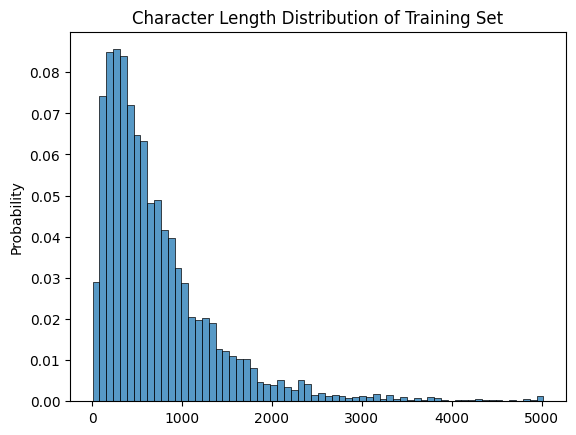

In [ ]:
lengths = [len(i) for i in train["text"]]
sns.histplot(x=lengths, stat="probability").set(title="Character Length Distribution of Training Set")

Unsurprisngly, the lengths of the data is highly skewed which means our truncator will come into use.

Let's look at the most common adjectives by class as I imagine those will be key features learned by the model

In [ ]:
print("-----Train-----")
top_adjectives_by_class(dataset=train, n=10)

print("-----Val-----")
top_adjectives_by_class(dataset=val, n=10)

print("-----Test-----")
top_adjectives_by_class(dataset=test, n=10)

-----Train-----


Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5200 [00:00<?, ? examples/s]

,Label,Most Common
0,0,"[(just, 331), (like, 325), (out, 321), (about, 297), (one, 287), (all, 268), (even, 267), (back, 224), (here, 218), (only, 213)]"
1,1,"[(just, 393), (like, 391), (good, 304), (very, 294), (out, 293), (one, 288), (all, 286), (about, 280), (only, 260), (here, 256)]"
2,2,"[(good, 395), (just, 352), (like, 346), (out, 283), (some, 270), (all, 270), (here, 266), (very, 259), (one, 243), (about, 237)]"
3,3,"[(good, 379), (very, 312), (like, 304), (all, 264), (out, 253), (great, 248), (here, 243), (some, 240), (one, 220), (about, 211)]"
4,4,"[(great, 269), (very, 248), (out, 234), (like, 233), (all, 232), (good, 222), (here, 217), (just, 211), (one, 202), (about, 186)]"


-----Val-----


Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1300 [00:00<?, ? examples/s]

,Label,Most Common
0,0,"[(out, 85), (just, 78), (like, 77), (all, 75), (one, 67), (about, 64), (back, 63), (even, 55), (after, 55), (told, 54)]"
1,1,"[(just, 95), (like, 89), (one, 79), (good, 73), (about, 73), (very, 72), (out, 71), (all, 68), (here, 68), (some, 63)]"
2,2,"[(good, 86), (just, 85), (out, 83), (like, 77), (about, 75), (some, 74), (one, 71), (all, 70), (very, 67), (here, 66)]"
3,3,"[(good, 80), (like, 77), (very, 70), (all, 69), (only, 62), (great, 62), (out, 62), (just, 59), (here, 59), (back, 57)]"
4,4,"[(great, 66), (all, 62), (out, 61), (like, 58), (very, 56), (just, 55), (about, 53), (here, 52), (one, 51), (good, 49)]"


-----Test-----


Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2500 [00:00<?, ? examples/s]

,Label,Most Common
0,0,"[(out, 154), (one, 152), (all, 142), (like, 138), (about, 138), (just, 137), (even, 117), (only, 109), (back, 102), (told, 97)]"
1,1,"[(like, 185), (just, 168), (out, 156), (one, 133), (good, 131), (very, 128), (all, 128), (about, 120), (here, 119), (some, 108)]"
2,2,"[(good, 165), (like, 163), (just, 162), (out, 150), (here, 143), (very, 139), (one, 131), (all, 124), (about, 122), (more, 115)]"
3,3,"[(good, 167), (very, 142), (just, 133), (like, 129), (out, 124), (all, 124), (some, 124), (great, 124), (one, 117), (here, 110)]"
4,4,"[(very, 141), (great, 140), (all, 131), (here, 110), (like, 107), (out, 106), (one, 104), (just, 101), (best, 98), (good, 94)]"


Welp, that was far less informative than I thought. I could play around with part-of-speech tagging, but that is out of scope for this

# 1.1) Train 🤖

## Try LLAMA with LORA Supervised Instruction Fine-Tuning and quantizing [IGNORE - CUDA MEMORY ERRORS]

In [ ]:
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [ ]:
# import os
# import torch
# import pandas as pd

# from datasets import load_dataset
# from transformers import (
#     AutoModelForCausalLM,
#     AutoModelForSequenceClassification,
#     AutoTokenizer,
#     BitsAndBytesConfig,
#     HfArgumentParser,
#     TrainingArguments,
#     pipeline,
#     logging,
#     DataCollatorWithPadding,
# )
# from peft import LoraConfig, PeftModel
# from trl import SFTTrainer
# from typing import Iterable, Tuple
# from datasets.arrow_dataset import Dataset
# from tqdm import tqdm
# from sklearn.metrics import mean_squared_error

In [ ]:
# def make_instruction(example):
#   return {"instruction": f'<s>[INST] Predict the rating from 0-4 of the following Yelp review: {example["text"]} [/INST] {example["label"]} </s>'}


# train = train.map(make_instruction)
# val = val.map(make_instruction)
# test = test.map(make_instruction)

In [ ]:

# class Classifier:
#     """
#     Class with all the functionality to prepare data, train, and evaluate a language model
#     """

#     def __init__(self, model_name: str) -> None:
#         """

#         Parameters:

#             model_name (`str`): Name of pre-trained model on HuggingFace Hub

#         """

#         bnb_config = BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_quant_type="nf4",
#             bnb_4bit_compute_dtype="float16",
#             bnb_4bit_use_double_quant=False,
#         )

#         major, _ = torch.cuda.get_device_capability()

#         self.model = AutoModelForCausalLM.from_pretrained(
#             model_name,
#             quantization_config=bnb_config,
#             device_map={"": 0},
#         )
#         self.model.config.use_cache = False
#         self.model.config.pretraining_tp = 1

#         self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
#         self.tokenizer.pad_token = tokenizer.eos_token
#         self.tokenizer.padding_side = "right"


#     def train(self, train: Dataset, test: Dataset) -> None:

#         """

#         Uses HuggingFace trainer to train the model

#         Parameters:

#             train (`Dataset`): Training data with `instruction` column
#             test (`Dataset`): Evaluation data with `instruction` column

#         """

#         peft_config = LoraConfig(
#             lora_alpha=16,
#             lora_dropout=0.1,
#             r=64,
#             bias="none",
#             task_type="CAUSAL_LM",
#         )

#         training_arguments = TrainingArguments(
#             output_dir="trained_models",
#             num_train_epochs=1,
#             per_device_train_batch_size=4,
#             gradient_accumulation_steps=1,
#             optim="paged_adamw_8bit",
#             save_steps=0,
#             logging_steps=25,
#             learning_rate=2e-4,
#             weight_decay=0.001,
#             fp16=False,
#             bf16=False,
#             max_grad_norm=0.3,
#             warmup_ratio=0.06,
#             group_by_length=True,
#             lr_scheduler_type="cosine",
#             report_to="tensorboard",
#         )


#         self.trainer = SFTTrainer(
#             model=self.model,
#             train_dataset=train,
#             peft_config=peft_config,
#             dataset_text_field="instruction",
#             max_seq_length=2048,
#             tokenizer=self.tokenizer,
#             args=training_arguments,
#             packing=False,
#         )

#         self.trainer.train()
#         self.trainer.model.save_pretrained("yelp_model_test")


#     def load_trained_model(self, model_name: str, trained_model: str) -> Tuple[AutoModelForCausalLM, AutoTokenizer]:

#         """

#         Parameters:

#           model_name (`str`): Name of pre-trained model on HuggingFace Hub
#           trained_model (`str`): Name of local fine tuned model

#         """

#         base_model = AutoModelForCausalLM.from_pretrained(
#             model_name,
#             low_cpu_mem_usage=True,
#             return_dict=True,
#             torch_dtype=torch.float16,
#             device_map={"": 0},
#         )
#         model = PeftModel.from_pretrained(base_model, trained_model)
#         model = model.merge_and_unload()

#         tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, model_max_length=2048)
#         tokenizer.pad_token = tokenizer.eos_token
#         tokenizer.padding_side = "right"

#         return (model, tokenizer)



#     def evaluate(self, model_name: str, trained_model: str, test: Dataset) -> dict:

#         """

#         Parameters:

#               model_name (`str`): Name of pre-trained model on HuggingFace Hub
#               trained_model (`str`): Name of local fine tuned model
#               test (`Dataset`): Evaluation data with `instruction` column

#         """

#         logging.set_verbosity(logging.CRITICAL)


#         model, tokenizer = self.load_trained_model(model_name, trained_model)

#         pipe = pipeline(
#             task="text-generation",
#             model=model,
#             tokenizer=tokenizer,
#             return_full_text=False,
#             temperature=0,
#             max_new_tokens=2,
#             )


#         results = []

#         for example in tqdm(test):

#           results.append({
#               "labels": example["label"],
#               "predictions": pipe(f"<s>[INST] Predict the rating from 0-4 of the following Yelp review: {example['text']} [/INST]")[0]["generated_text"],
#           })


#         results = pd.DataFrame(results)
#         mse = mean_squared_error(results["labels"], results["predictions"])

#         return {"results": results, "mse": mse}

In [ ]:
# classifier = Classifier(model_name = "NousResearch/Llama-2-7b-chat-hf")

In [ ]:
# classifier.train(train, val)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# result = classifier.evaluate(train, val)
# print(result["mse"])

## Use Ernie Sequence Classifier Instead

In [ ]:

class Classifier:
    """
    Class with all the functionality to prepare data, train, and evaluate a transformer model
    """

    def __init__(self, config: dict) -> None:
        """

        Parameters:

            config (`dict`): Contains custom configurations for model

        """

        self.config = config
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(self.config["model_name"], fast=True)
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.config["model_name"], num_labels=self.config["num_labels"]).to(self.device)


    def tokenize(self, examples: dict) -> dict:
        """
        Converts dictionary with a list of texts into dictionary of tokens and truncated tokens to the max length provided in the model config

        Parameters:

            examples (dict): Data dictionary with list of texts

        """
        return self.tokenizer(examples["text"], truncation=True, max_length=self.config["max_length"], return_tensors='pt', padding=True).to(self.device)


    def logit_to_score(self, logit):

        """
        """

        score_layer = torch.nn.Softmax(dim=1)
        return score_layer(logit.float()).detach().cpu().numpy()


    def compute_metrics(self, outs: Tuple[Iterable, Iterable]) -> dict:
        """

        Computes Mean Squared Error as specified by the task

        Parameters:

            outs (`Tuple` of `Iterable` objects)

        """

        logits, labels = outs
        scores = self.logit_to_score(torch.from_numpy(logits))
        predictions = np.argmax(scores, axis=1)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
        acc = accuracy_score(labels, predictions)
        mse = mean_squared_error(labels, predictions)
        return {"mse": mse, "prec": prec, "rec": rec, "f1": f1, "acc": acc}


    def train(self, train: Dataset, test: Dataset) -> None:

        """

        Uses HuggingFace trainer to train the model

        Parameters:

            train (`Dataset`): Training data with text and labels
            test (`Dataset`): Evaluation data with text and labels

        """

        train = train.map(self.tokenize, batched=True)
        test = test.map(self.tokenize, batched=True)

        training_args = TrainingArguments(
            output_dir= "model_checkpoints",
            learning_rate= self.config["learning_rate"],
            warmup_ratio= self.config["warmup"],
            weight_decay= self.config["weight_decay"],
            #optim="adamw_hf",
            #lr_scheduler_type="linear",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            evaluation_strategy = "steps",
            eval_steps=100,
            logging_steps=100,
            save_strategy = "steps",
            save_total_limit = 2,
            auto_find_batch_size= True,
            gradient_checkpointing=True,
            gradient_accumulation_steps= self.config["gradient_accumulation_steps"],
            num_train_epochs= self.config["num_epochs"],
            group_by_length= True,
            metric_for_best_model = "mse",
            greater_is_better = False,
            load_best_model_at_end= True,
            fp16= self.config["mixed_precision"],
            seed = 22,
            push_to_hub= False,
            #report_to="tensorboard",
        )

        self.trainer = Trainer(
            model= self.model,
            args= training_args,
            train_dataset= train,
            eval_dataset= test,
            tokenizer= self.tokenizer,
            data_collator= self.data_collator,
            compute_metrics= self.compute_metrics,
            callbacks = [
                EarlyStoppingCallback(
                                    early_stopping_patience= self.config["patience"],
                                    early_stopping_threshold= self.config["stopping_threshold"],
                                    ),
                ProgressCallback,
                ],
            optimizers = self.load_optimizer(train_len=len(train)),
        )

        print(f"Training on {self.model.device}")
        self.trainer.train()
        self.trainer.model.save_pretrained("yelp_model")



    def load_optimizer(self, train_len: int, no_decay: list = ["bias", "LayerNorm.weight"], lr_decay: float=0.95,) -> Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR]:

        """

        Loads AdamW optimiser with AMSGRAD and a linear scheduler with warmup

        Parameters:

            train_len (`int`): Length of training data
            no_decay (`list`): List of model parameters not to apply weight decay to
            lr_decay (`float`): Rate at which to decay learning rate by layer


        """

        optimizer_grouped_parameters = []

        try:

            for n, p in self.model.named_parameters():
                param_dict = {
                    "params": p,
                    "weight_decay": 0.01,
                    "learning_rate": self.config["learning_rate"],
                }

                if "layer" in n:
                    layer_n = int(n.split(".")[3])
                    param_dict["learning_rate"] = lr_decay**layer_n * self.config["learning_rate"]

                for nd in no_decay:
                    if nd in n:
                        param_dict["weight_decay"] = 0.0

                optimizer_grouped_parameters.append(param_dict)


        except:
            optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                    "weight_decay": 0.01,
                },
                {
                    "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                    "weight_decay": 0.0,
                },
            ]

        total_steps = math.ceil(self.config["num_epochs"] * max(train_len // self.config["gradient_accumulation_steps"], 1))
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config["learning_rate"], eps=1e-8, amsgrad=True)
        scheduler = get_linear_schedule_with_warmup(
                                                    optimizer=optimizer,
                                                    num_warmup_steps=self.config["warmup"]*total_steps,
                                                    num_training_steps=total_steps,
                                                    )

        return (optimizer, scheduler)



    def predict():
        return

## Load Model

Here is where I set the hyperparameters for the model. Frist, I will be using an [Ernie](https://ojs.aaai.org/index.php/AAAI/article/view/6428) transformer architecture because it is the [best performing](https://gluebenchmark.com/leaderboard/) open-sourced model on a related sentiment classification task (SST2-2). The rest are standard parameters, but I will be using mixed precision training to reduce the memory footprint.

In [ ]:
# Define Config

config = {
    "model_name": "nghuyong/ernie-2.0-large-en",
    "max_length": 512,
    "learning_rate": 2e-5,
    "num_epochs": 5,
    "warmup": 0.06,
    "weight_decay": 0,# 0.01,
    "patience": 2,
    "stopping_threshold": 0.0,
    "mixed_precision": True,
    "num_labels": len(set(train["label"])),
    "gradient_accumulation_steps": 1,
}


classifier = Classifier(config=config)

Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-large-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train

Finally, training time! The model will be trained for 5 epochs with early stopping to prevent overfitting. Parameters will be optimized with [AdamW](https://arxiv.org/abs/1711.05101) with [AMSGrad](https://openreview.net/pdf?id=ryQu7f-RZ). The learning rate will be controlled by a linear scehedule and [decayed by layer](https://arxiv.org/pdf/1510.04609.pdf) to prevent catastrophic forgetting at the lower levels.

In [ ]:
classifier.train(train=train, test=val)

Map:   0%|          | 0/5200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

Training on cuda:0


  0%|          | 0/1625 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Mse,Prec,Rec,F1,Acc
100,1.650000,1.578701,4.256923,0.276769,0.280000,0.189183,0.280000
200,1.364100,1.038785,0.560769,0.623194,0.553077,0.526411,0.553077
300,0.964200,0.919151,0.558462,0.589243,0.591538,0.569813,0.591538
400,0.857400,0.833158,0.458462,0.618817,0.626923,0.620009,0.626923
500,0.799700,0.848225,0.442308,0.658584,0.634615,0.638723,0.634615
600,0.796200,0.817820,0.446154,0.634497,0.643077,0.635683,0.643077
700,0.703000,0.870063,0.436154,0.645958,0.642308,0.642986,0.642308
800,0.635600,0.887658,0.462308,0.646610,0.632308,0.632813,0.632308
900,0.653100,0.933502,0.526154,0.609535,0.606923,0.587752,0.606923


{'loss': 1.65, 'learning_rate': 1.2435897435897437e-06, 'epoch': 0.31}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.578701138496399, 'eval_mse': 4.256923076923077, 'eval_prec': 0.27676861769435324, 'eval_rec': 0.28, 'eval_f1': 0.18918323889003022, 'eval_acc': 0.28, 'eval_runtime': 47.218, 'eval_samples_per_second': 27.532, 'eval_steps_per_second': 1.737, 'epoch': 0.31}
{'loss': 1.3641, 'learning_rate': 2.5256410256410257e-06, 'epoch': 0.62}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 1.0387849807739258, 'eval_mse': 0.5607692307692308, 'eval_prec': 0.6231942187196073, 'eval_rec': 0.553076923076923, 'eval_f1': 0.5264106469295174, 'eval_acc': 0.553076923076923, 'eval_runtime': 47.1897, 'eval_samples_per_second': 27.548, 'eval_steps_per_second': 1.738, 'epoch': 0.62}
{'loss': 0.9642, 'learning_rate': 3.8076923076923077e-06, 'epoch': 0.92}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.9191508889198303, 'eval_mse': 0.5584615384615385, 'eval_prec': 0.5892428528124329, 'eval_rec': 0.5915384615384616, 'eval_f1': 0.5698128518907755, 'eval_acc': 0.5915384615384616, 'eval_runtime': 47.2078, 'eval_samples_per_second': 27.538, 'eval_steps_per_second': 1.737, 'epoch': 0.92}
{'loss': 0.8574, 'learning_rate': 5.08974358974359e-06, 'epoch': 1.23}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.8331579566001892, 'eval_mse': 0.4584615384615385, 'eval_prec': 0.6188167490384685, 'eval_rec': 0.6269230769230769, 'eval_f1': 0.6200090399799764, 'eval_acc': 0.6269230769230769, 'eval_runtime': 47.4714, 'eval_samples_per_second': 27.385, 'eval_steps_per_second': 1.727, 'epoch': 1.23}
{'loss': 0.7997, 'learning_rate': 6.371794871794872e-06, 'epoch': 1.54}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.8482249975204468, 'eval_mse': 0.4423076923076923, 'eval_prec': 0.6585841657104036, 'eval_rec': 0.6346153846153846, 'eval_f1': 0.6387228672652058, 'eval_acc': 0.6346153846153846, 'eval_runtime': 47.2323, 'eval_samples_per_second': 27.524, 'eval_steps_per_second': 1.736, 'epoch': 1.54}
{'loss': 0.7962, 'learning_rate': 7.653846153846154e-06, 'epoch': 1.85}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.8178198933601379, 'eval_mse': 0.4461538461538462, 'eval_prec': 0.6344974243879457, 'eval_rec': 0.6430769230769231, 'eval_f1': 0.6356833937310106, 'eval_acc': 0.6430769230769231, 'eval_runtime': 46.9248, 'eval_samples_per_second': 27.704, 'eval_steps_per_second': 1.747, 'epoch': 1.85}
{'loss': 0.703, 'learning_rate': 8.935897435897438e-06, 'epoch': 2.15}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.8700634837150574, 'eval_mse': 0.43615384615384617, 'eval_prec': 0.645957959289755, 'eval_rec': 0.6423076923076924, 'eval_f1': 0.6429863292271291, 'eval_acc': 0.6423076923076924, 'eval_runtime': 47.1262, 'eval_samples_per_second': 27.586, 'eval_steps_per_second': 1.74, 'epoch': 2.15}
{'loss': 0.6356, 'learning_rate': 1.0217948717948718e-05, 'epoch': 2.46}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.8876582980155945, 'eval_mse': 0.4623076923076923, 'eval_prec': 0.6466099498395989, 'eval_rec': 0.6323076923076923, 'eval_f1': 0.6328127537455634, 'eval_acc': 0.6323076923076923, 'eval_runtime': 47.1648, 'eval_samples_per_second': 27.563, 'eval_steps_per_second': 1.739, 'epoch': 2.46}
{'loss': 0.6531, 'learning_rate': 1.15e-05, 'epoch': 2.77}


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.9335024952888489, 'eval_mse': 0.5261538461538462, 'eval_prec': 0.6095346856604481, 'eval_rec': 0.6069230769230769, 'eval_f1': 0.5877515062231453, 'eval_acc': 0.6069230769230769, 'eval_runtime': 47.1645, 'eval_samples_per_second': 27.563, 'eval_steps_per_second': 1.739, 'epoch': 2.77}
{'train_runtime': 2529.5455, 'train_samples_per_second': 10.279, 'train_steps_per_second': 0.642, 'train_loss': 0.9359092542860243, 'epoch': 2.77}


Looks like they might have slowed down free Colab GPUs because that per iteration time is much lower than what I'm used to on compute instances. At least the early stopping kicked in.

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Download files locally to avoid retraining
!zip -r yelp_model.zip yelp_model
!zip -r model_checkpoints.zip model_checkpoints

In [ ]:
from google.colab import files
files.download("yelp_model.zip")
files.download("model_checkpoints.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate

In [ ]:
# predictions = classifier.trainer.predict(test.map(classifier.tokenize, batched=True))

Crashes session because of RAM usage. Time to restart runtime and load fresh.

By default, the text classification pipeline returns only the score the predicted class. To get the scores for all of the data classes, I create a custom pipeline by subclassing and change the postprocess method.

In [ ]:
class CustomPipeline(TextClassificationPipeline):

    def softmax(self, _outputs):
        maxes = np.max(_outputs, axis=-1, keepdims=True)
        shifted_exp = np.exp(_outputs - maxes)
        return shifted_exp / shifted_exp.sum(axis=-1, keepdims=True)

    def postprocess(self, model_outputs, function_to_apply=None, top_k=1, _legacy=True):

        outputs = model_outputs["logits"][0]
        outputs = outputs.numpy()

        scores = self.softmax(outputs)

        return {"prediction": np.argmax(scores), "scores": scores}


In [ ]:

pipe = CustomPipeline(
    model= AutoModelForSequenceClassification.from_pretrained("/content/model_checkpoints/checkpoint-500"),
    tokenizer = AutoTokenizer.from_pretrained("/content/model_checkpoints/checkpoint-500", fast=True),
    device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu"),
    )

In [ ]:
outs = pipe(test["text"], padding=True, truncation=True, max_length=512)

In [ ]:
results = pd.DataFrame(outs)
results["text"] = test["text"]
results["label"] = test["label"]

In [ ]:
mse = mean_squared_error(results["label"], results["prediction"])
prec, rec, f1, _ = precision_recall_fscore_support(results["label"], results["prediction"], average='weighted')

print({
    "mse": mse,
    "precision": prec,
    "recall": rec,
    "f1": f1,
})

{'mse': 0.38, 'precision': 0.6867277804862137, 'recall': 0.656, 'f1': 0.6615742755510673}


An F1 of 0.66 is respectable and potentially useful for some tasks, but nothing to write home about

In [ ]:
del pipe

# 1.2) Regression 📈

In [ ]:
def weighted_score(scores: np.array):
    """

    Computes weighted average of model scores

    Parameters:

        scores (`np.array`): Array of 5 with a continous score from 0-1 corresponding to the probability the model gives a review for being a certain star score

    """
    return np.sum(np.multiply(scores, np.array([i for i in range(len(scores))])))

results["weighted_score"] = results["scores"].map(lambda x: weighted_score(x))

In [ ]:

fig = px.scatter(
    results,
    x='label',
    y='weighted_score',
    marginal_x='histogram',
    marginal_y='histogram',
    # color='label',
    # color_discrete_sequence=px.colors.qualitative.Plotly,
    trendline='ols',
    title="Weighted Scores vs Actual"
)

fig.update_traces(histnorm='probability', selector={'type':'histogram'})
fig.add_shape(
    type="line",
    line=dict(dash='dash'),
    x0= results["label"].min(),
    y0= results["weighted_score"].min(),
    x1= results["label"].max(),
    y1= results["weighted_score"].max(),
)

fig.show()

In [ ]:
ols_results = px.get_trendline_results(fig)
ols_results = ols_results.iloc[0]["px_fit_results"].summary()
print(ols_results)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     2672.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):          2.80e-202
Time:                        20:31:01   Log-Likelihood:                -332.59
No. Observations:                 500   AIC:                             669.2
Df Residuals:                     498   BIC:                             677.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5400      0.037     14.785      0.0

The slope of the regression line is 0.77 and the R2 is 0.843. A perfect classifier would have a slope and R2 of 1. A slope of less than one means the model over-predicts lower rated reviewed and under-predicts higher rated ones. The p-value for that is significant meaning we are more than 95% confident that the slope is greater than zero (i.e. the classifier is discovering some relationship between the text and the labels). The R2 means that 84% of the variance in the labels is captured by the model's scores.

A poisson or negative binomial regression would likely provide a better fit as the output data is discrete and confined.

# 1.3) Error Analysis

In [ ]:
results["error"] = abs(results["label"] - results["weighted_score"])

In [ ]:
results["error"].describe()

count    500.000000
mean       0.448142
std        0.364219
min        0.002778
25%        0.153490
50%        0.363359
75%        0.682878
max        2.059800
Name: error, dtype: float64

In [ ]:
results.sort_values(by="error", ascending=False).head(10)

,prediction,scores,text,label,weighted_score,error
297,2,"[0.04293954, 0.10443521, 0.62913764, 0.1968607, 0.026626905]","The hotel for the price range and the star rating is fair. \n\nOne thing i will complain about is the staff. Of all the hotel stays i've ever done (and i've had my generous share of moving around on a budget and in luxury) i have never met a most unprofessional, discourteous, and sarcastic staff who work in hotels. You ask for something (airconditioning) and staff asks for a minute (and he returns on facebook... I came back in 2 minutes and asked and was lectured to not expect it to be done immediately, while his computer screen was still on facebook. \n\nStayed from 25-27 august 2012.\n\nNEVER STAY HERE!!!!",0,2.059800,2.059800
300,3,"[0.0073933834, 0.013840752, 0.124354064, 0.7020286, 0.15238325]","Obviously its not the best place to stay when you're in Vegas, but you know what, the service staff is nice, and the location is great! Smack dab in the middle of the strip.. If you don't want to spend a lot of $$ on a hotel room this is the place for you!",1,2.978168,1.978168
461,2,"[0.016871264, 0.20155565, 0.72814083, 0.045835633, 0.0075966725]","Seems a little small and cramped. Location is ok, prices cheap. Salesmen have a weird vibe- you can tell they have so many ulterior motives than to actually provide real customer service.",0,1.825731,1.825731
175,2,"[0.017952157, 0.22310989, 0.7162871, 0.037581217, 0.0050695767]","I was so excited to revisit the old Agave. I love the outside patio. Unfortunately, it was too hot for my taste. We were seated by the door and it was still pretty warm inside. I did enjoy the chips and salsa. However, my sangria was sample sized. We order the ceviche duo with shrimp and tuna. There might have been one or two (very small) chopped shrimp and a few bits of tuna. Since I was so warm, I ordered the chopped salad. It was bland. Won't be back again.",0,1.788706,1.788706
472,3,"[0.008656626, 0.02342413, 0.41473246, 0.48897302, 0.064213835]","I must've come here on a bad day considering all of the other glowing reviews. I've got two things to say about this place: \n\na) It's very affordable.\nb) Up until I visited this place, I thought pizza was like sex. That is, there's no such thing as bad sex. Well, the Floridino's pizza just kinda laid there.\n\nI should probably try it again, even though my first visit was underwhelming. One more minor note, this place also has a full bar and it's the first thing you see when you walk into the place. Not sure why that survey question has been answered differently by every other user.",1,2.576663,1.576663
488,3,"[0.028317612, 0.03878857, 0.40266016, 0.4063148, 0.123918846]","Holy Spinach! \n\nSo, my partner and I ordered the vegetarian version of their philly cheesesteaks. It was slimy spinach, a little onion, a little pepper, a little cheese, covered (slathered, soaked, drenched) in oil and vinegar.\n\nI didn't request oil or vinegar, and it wasn't an option presented to me online when I ordered. And the spinach... oh, my, gawd. I grew up on a farm in Southeastern Ohio and I've never seen so much spinach crammed into such a small place. Seriously - there are other vegetables. Lots of other vegetables.\n\nTheir onion rings, though, are pure art. They are the most delicious onion rings I've ever put anywhere near my mouth, with the exception of Oak Creek in Sedona and Sun Up in Phoenix.",1,2.558729,1.558729
385,1,"[0.042480897, 0.49037713, 0.43575516, 0.026622659, 0.004764116]","The Angus Reserve Burger at $12 was a frozen patty cooked to whatever the chef feels like cooking. If you looking for food or drinks there are other places in Pittsburgh. Come on Tap room, how many local breweries are located around Pittsburgh. Update your selection",0,1.460812,1.460812
407,1,"[0.087402634, 0.53240246, 0.31408644, 0.050899003, 0.01520942]","Rip off 2.79 with car wash otherwise 3.09 what a rip.\nGas down the street is only 2.79 without the car wash , ic

A median error of 0.36 stars is pretty good, but there are a handful where the error is greater than 1.5. Some of the errors seem way off (e.g. idx 297), while other reflect more an individual's skewed rating scale (e.g. idx 300). Most commonly, the model messes up when the reviewed includes some positive or neutral statements alongside much more negative ones.

A tool like [BertViz](https://github.com/jessevig/bertviz) could help visualize the model's attention to see which words it is under/over emphasizing

# 1.4) Future Work

- Preprocessing
    - Filter out any non-English data that might be present (when not using a multilingual model) or potential mislabed data (e.g. [Confident Learning](https://github.com/cleanlab/cleanlab))
    - Split documents when longer than max token length and then averaging their score instead of naive truncation
    - I'd probably want to encode topic/category as a feature (using something like [BERTopic](https://maartengr.github.io/BERTopic/index.html)) for the classifier because descriptors like "sick" mean opposite things when the review is about a restaurant vs an attraction
- Training
    - With more compute, I'd run the LLAMA code and train across the full dataset
    - Hyperparemeter search with a package like [tune](https://docs.ray.io/en/latest/tune/index.html)
    - I'd integrate [DeepSpeed](https://github.com/microsoft/deepspeed) for training speed
- Inference
    - To lower latency, I'd quanitize the model with either [GPTQ](https://arxiv.org/abs/2210.17323) or [TensorRT](https://developer.nvidia.com/tensorrt-getting-started)
- General
    - I'd migrate the code to a python library with proper tests (e.g. [pytests](https://docs.pytest.org/en/7.4.x/)), dependency management (e.g. [poetry](https://python-poetry.org/)), containerization (e.g. [Docker](https://www.docker.com/), and CI/CD (e.g. [GitHub Actions](https://github.blog/2022-02-02-build-ci-cd-pipeline-github-actions-four-steps/]) and add experiment logging (e.g. [MLFlow](https://mlflow.org/)